# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [24]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

### 2. Data Import <a id='read_data'></a>

In [2]:
data_file = '../data/big_demand_temp.csv'

In [3]:
full_df = pd.read_csv(data_file, index_col=0)

#### 2.A Clean the data frame <a id='clean_data'></a>

In [4]:
# Convert the time string to a datetime object
dt_time = [parser.isoparse(x) for x in full_df.loc[:, 'time']]
full_df.index = pd.DatetimeIndex(dt_time)
full_df.drop('time', axis=1, inplace=True)
full_df.sort_index(inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41114 entries, 2015-07-01 08:00:00+00:00 to 2020-03-09 14:00:00+00:00
Data columns (total 7 columns):
demand           41114 non-null int64
Los Angeles      41114 non-null float64
San Diego        41114 non-null float64
San Jose         41114 non-null float64
San Francisco    41114 non-null float64
Sacramento       41114 non-null float64
Fresno           41114 non-null float64
dtypes: float64(6), int64(1)
memory usage: 2.5 MB


In [5]:
full_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37


#### Extending Exogenous Regressors To Include Day Of Week

In [6]:
days = [x.weekday() for x in full_df.index]
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df['DOW'] = days
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names
new_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,0,0,1,0,0,0,0,2
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,0,0,1,0,0,0,0,2
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,0,0,1,0,0,0,0,2
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,0,0,1,0,0,0,0,2
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,0,0,1,0,0,0,0,2


#### 2.B Data Split <a id='data_split'></a>

In [7]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [8]:
# Split the data frame into two parts
train_len = int(0.5 * data_len)
window_len = int(0.1 * data_len)
validation_len = int(0.8 * data_len)

In [9]:
# Make the primary train/validation split
X_train = new_df.iloc[:validation_len, :]
X_val = new_df.iloc[validation_len:, :]


In [10]:
# Save the test data to a csv file
X_val.to_csv('../data/big_demand_temp_validation.csv')
X_train.to_csv('../data/big_demand_temp_train.csv')

In [11]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [12]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20557 entries, 2015-07-01 08:00:00+00:00 to 2017-11-03 20:00:00+00:00
Data columns (total 15 columns):
demand           20557 non-null int64
Los Angeles      20557 non-null float64
San Diego        20557 non-null float64
San Jose         20557 non-null float64
San Francisco    20557 non-null float64
Sacramento       20557 non-null float64
Fresno           20557 non-null float64
Mon              20557 non-null uint8
Tue              20557 non-null uint8
Wed              20557 non-null uint8
Thur             20557 non-null uint8
Fri              20557 non-null uint8
Sat              20557 non-null uint8
Sun              20557 non-null uint8
DOW              20557 non-null int64
dtypes: float64(6), int64(2), uint8(7)
memory usage: 1.5 MB


### 3. Helper Functions <a id='helper'></a>

In [13]:
# This funtion tests the stationarity of the data set
#   The function was originally published as part of the Blog post
#
#   https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
#
#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

### 4. Data Analysis <a id='analysis'></a>

#### 4.1 Stationarity Testing <a id='stationarity'></a>

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


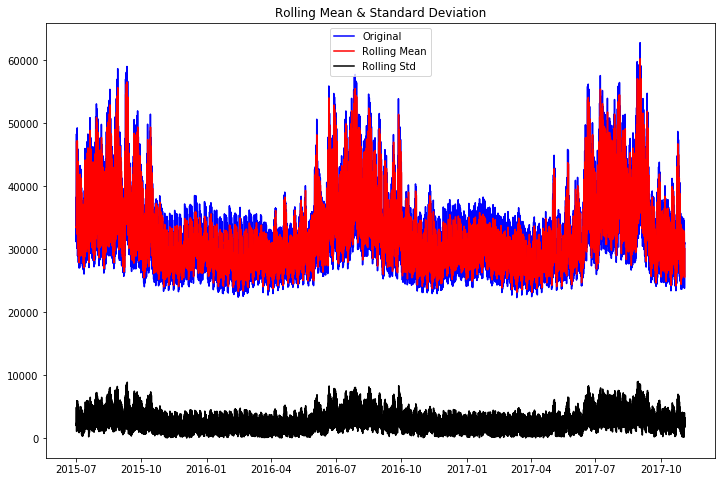

Results of Dickey-Fuller Test:
p-value = 0.0008. The series is likely stationary.
Test Statistic                    -4.142402
p-value                            0.000823
#Lags Used                        20.000000
Number of Observations Used    20536.000000
Critical Value (1%)               -3.430668
Critical Value (5%)               -2.861681
Critical Value (10%)              -2.566845
dtype: float64


In [14]:
test_stationarity(X_train.demand, window=8)

#### 4.2 Autocorrelation <a id='autocorr'></a>

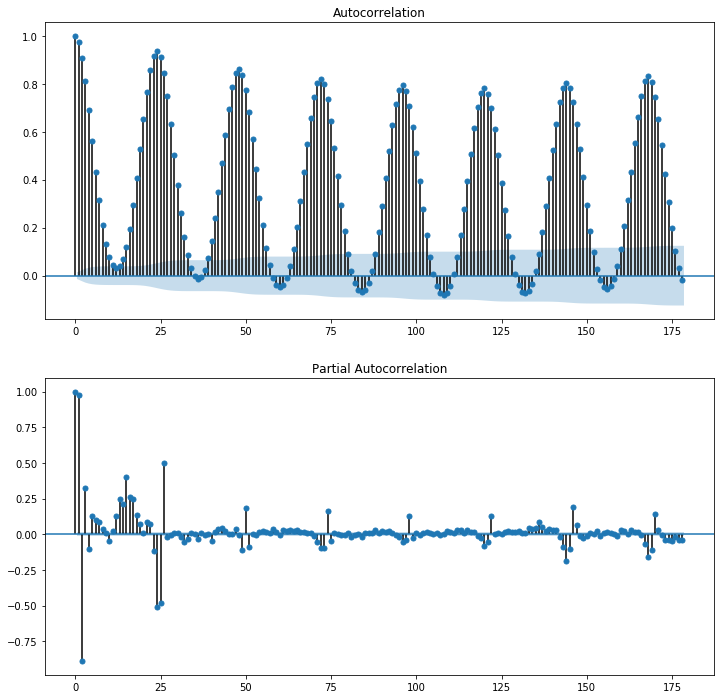

In [15]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train['demand'], lags=24*7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train['demand'], lags=24*7+10, ax=ax2)# , lags=40

#### 4.3 Seasonal Decomposition <a id='seasonal_decomp'></a>

In [16]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(X_train.demand, period=24, model='additive')

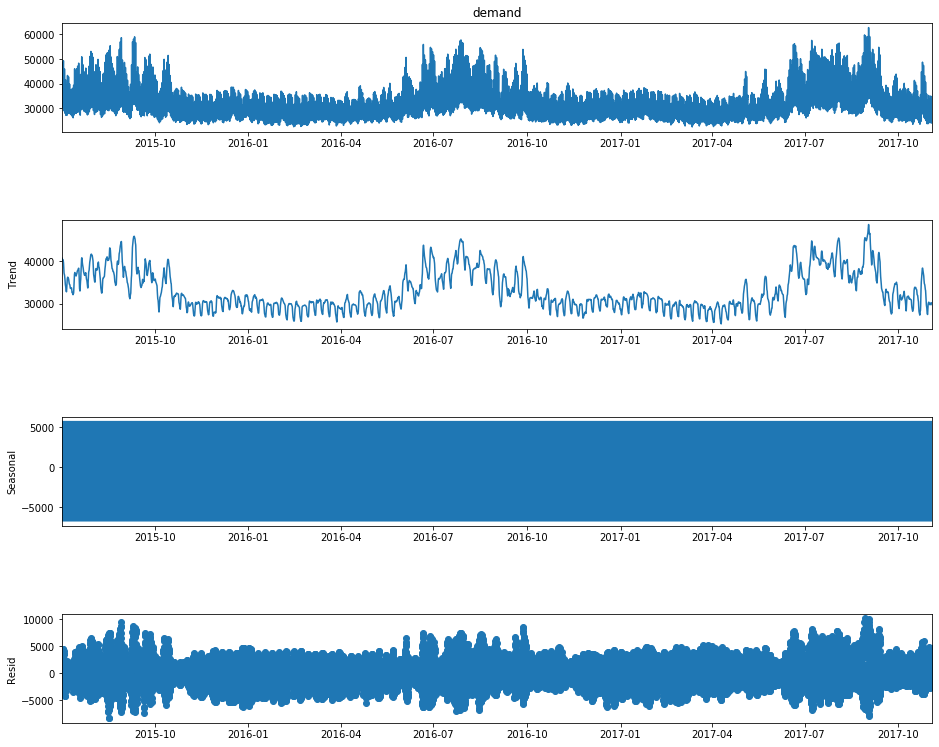

In [17]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

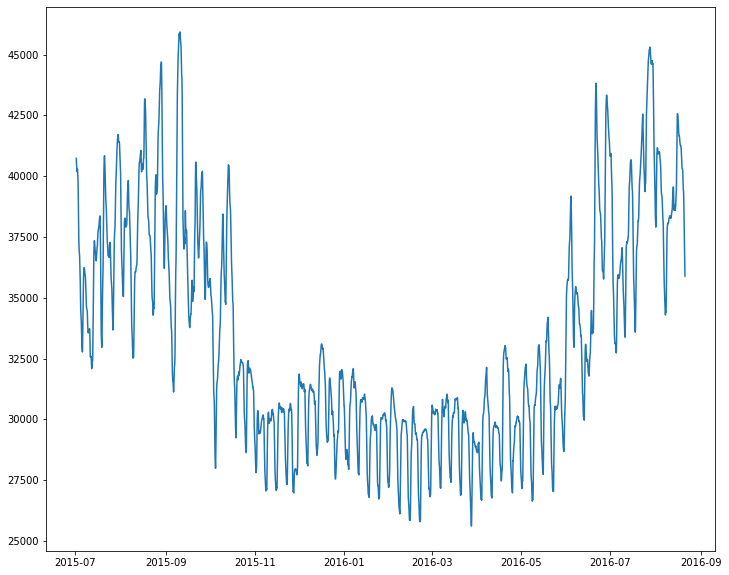

In [18]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

#### 4.4 Trend Autocorrelation <a id='trend_auto'></a>

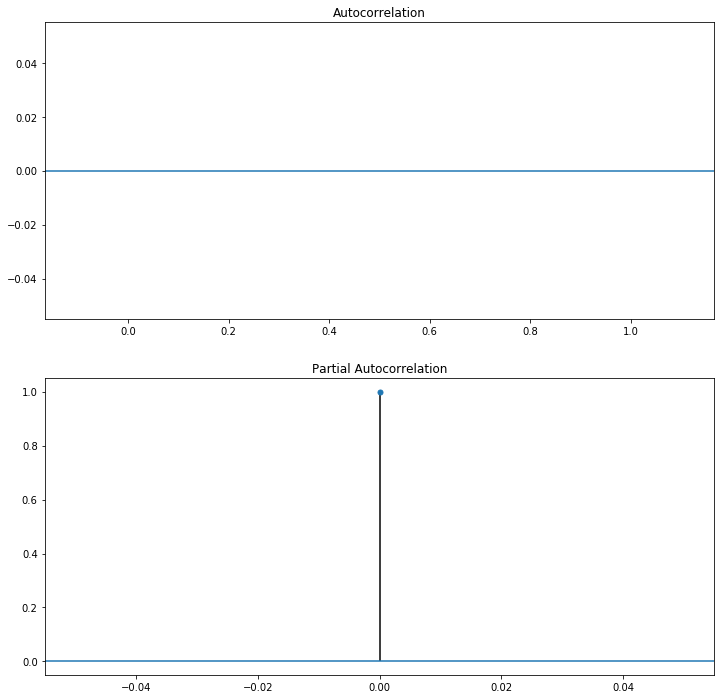

In [19]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomp_data.trend, lags=24*7+10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomp_data.trend, lags=24*7+10, ax=ax2)

### 5. Modeling <a id='modeling'></a>

#### 5.1 SARIMAX Without Exogeneous Data <a id='SARI_NoX'></a>

In [21]:
# Define the model for SARIMAX just using the demand data
seasonal_model1 = SARIMAX(X_train['demand'], simple_differencing=True, \
    order=(5, 0, 3), seasonal_order=(5,0,0,24))

res1 = seasonal_model1.fit()

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
print(res1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               demand   No. Observations:                20557
Model:             SARIMAX(10, 0, 3)x(5, 0, [], 24)   Log Likelihood             -153242.789
Date:                              Tue, 17 Mar 2020   AIC                         306523.578
Time:                                      10:14:58   BIC                         306674.266
Sample:                                  07-01-2015   HQIC                        306572.813
                                       - 11-03-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8642      0.015     56.794      0.000       0.834       0.894
ar.L2          1.65

In [25]:
# Save the trained model
filename = 'SARIMAX_wo_exog.sav'
pickle.dump(seasonal_model1, open(filename, 'wb'))

In [26]:
demand_hat = res1.fittedvalues

##### 5.1.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

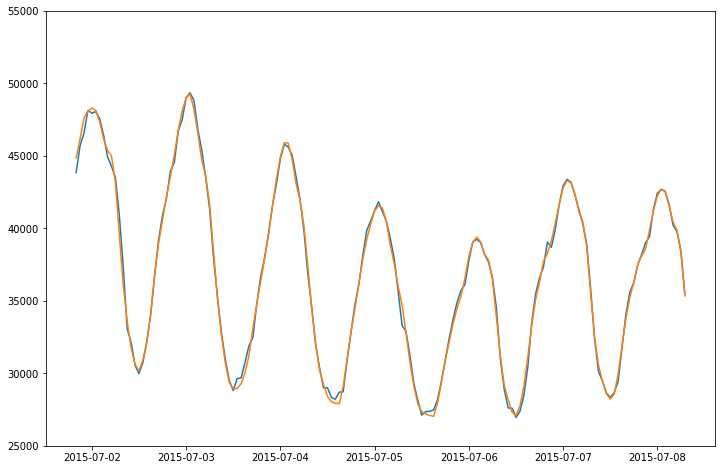

In [27]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(25000, 55000)

plt.plot(demand_hat[12:168])
plt.plot(X_train.index[12:168], X_train['demand'].values[12:168])

##### 5.1.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  <a id='plot-SARI_fit_wide'></a>

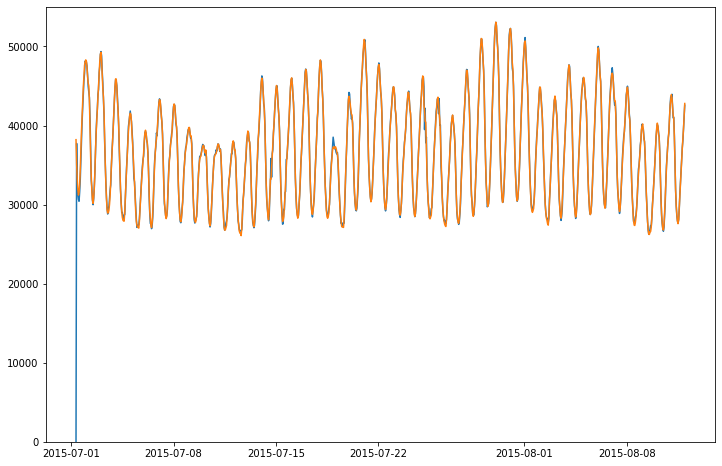

In [28]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)

plt.plot(demand_hat[:1000])
actual = X_train['demand'].values[12:1012]
plt.plot(X_train.index[0:1000], X_train['demand'].values[0:1000])

----
----

##### 5.1.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [42]:
predict_steps = 168*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = predict1.conf_int(alpha=0.5)
pred_vals1 = predict1.predicted_mean

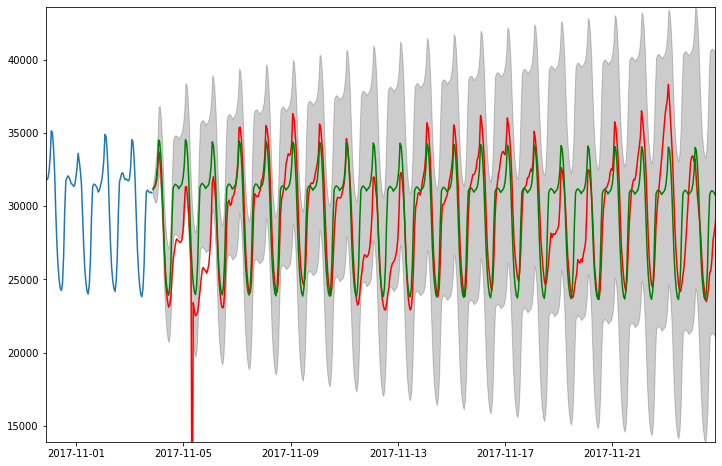

In [43]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times1))
plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index, X_train['demand'].values)
plt.plot(X_walk1.index, X_walk1['demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

(0, 7000)

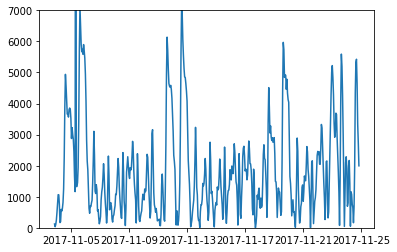

In [44]:
residuals = [abs(X_walk1['demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
plt.plot(pred_times1, residuals)
plt.ylim(0, 7000)

In [49]:
aic1 = res1.aic

306523.5780445073

#### 5.2 SARIMAX With Exogeneous Data

In [32]:
# The trailing columns are city temperatures and state population
city_temps_pop = X_train.columns[1:8]

In [ ]:
# Define the seasonal model with exogenous data
seasonal_model2 = SARIMAX(X_train['demand'], exog=X_train[city_temps_pop], simple_differencing=True, \
    order=(3, 1, 3), seasonal_order=(4,0,0,24))

res2 = seasonal_model2.fit()
print(res2.summary())

In [34]:
# Save the trained model
filename = 'SARIMAX_w_exog.sav'
pickle.dump(seasonal_model2, open(filename, 'wb'))

In [35]:
demand_hat2 = res2.fittedvalues

##### 5.2.1 SARIMAX With Exogeneous Data - Fit Plot Close <a id='plot-SARI_exog_fit_zoom'></a>

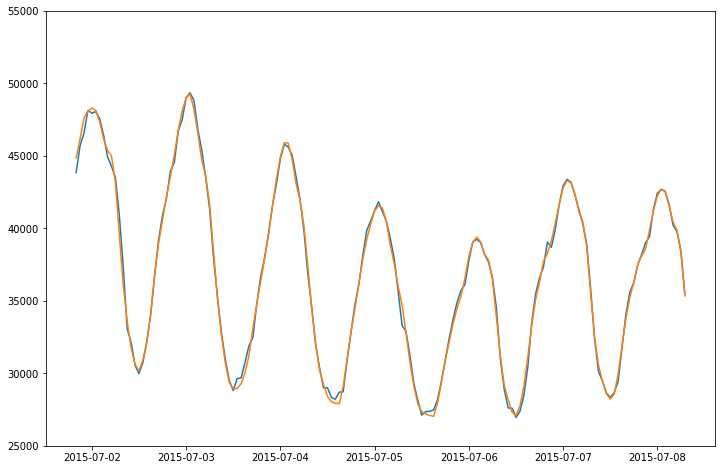

In [36]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(25000, 55000)

plt.plot(demand_hat[12:168])
plt.plot(X_train.index[12:168], X_train['demand'].values[12:168])

##### 5.2.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month <a id='plot-SARI_exof_fit_zoom'></a>

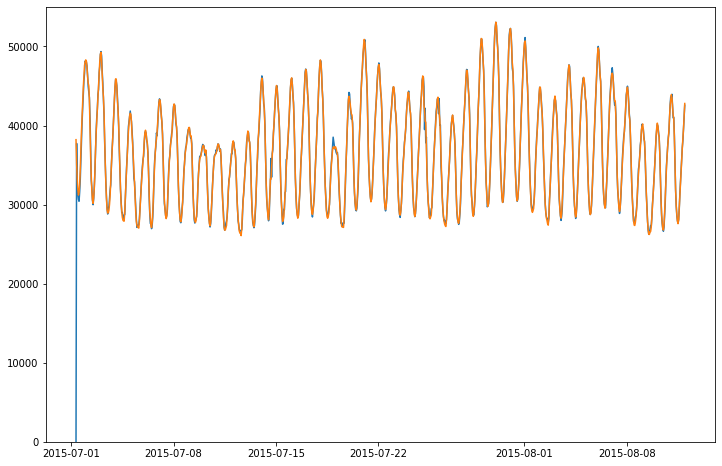

In [37]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)

plt.plot(demand_hat[:1000])
actual = X_train['demand'].values[12:1012]
plt.plot(X_train.index[0:1000], X_train['demand'].values[0:1000])

##### 5.2.3 SARIMAX With Exogeneous Data - Forecast  <a id='forecast-SARI_exog'></a>

In [45]:
predict_steps = 168*3
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[city_temps_pop].values[:predict_steps, :])
pred_ci2 = predict2.conf_int(alpha=0.5)
pred_vals2 = predict2.predicted_mean

In [48]:
aic2 = res2.aic

309250.18212473305

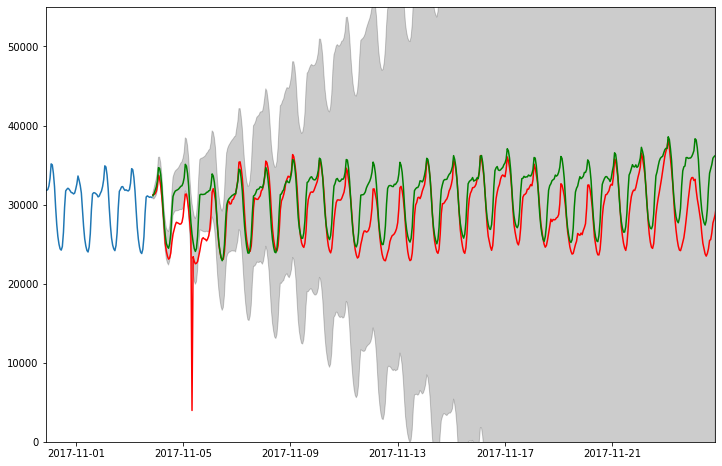

In [46]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index, X_train['demand'].values)
plt.plot(X_walk1.index, X_walk1['demand'].values, c='r')
plt.plot(pred_times2, pred_vals2.values, c='g')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2)

(0, 10000)

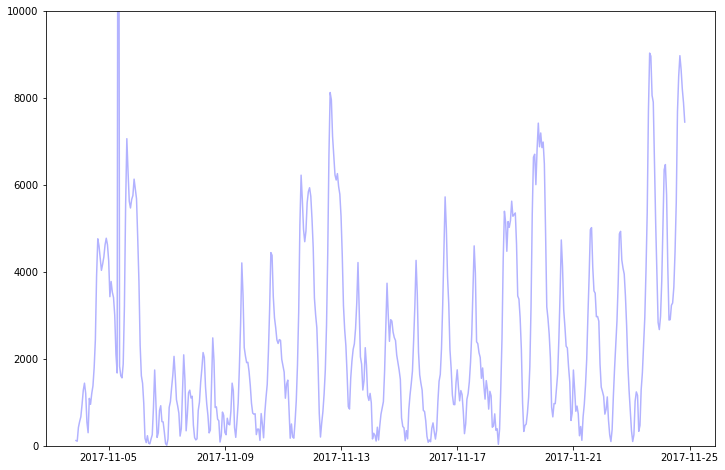

In [47]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)
plt.ylim(0, 10000)

#### 5.3 SARIMAX With Extended Exogeneous Data

In [50]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_dat = X_train.columns[1:-1]

In [51]:
# Define the seasonal model with exogenous data
seasonal_model3 = SARIMAX(X_train['demand'], exog=X_train[all_exog_dat], simple_differencing=True, \
    order=(10, 0, 4), seasonal_order=(5,0,0,24))

res3 = seasonal_model3.fit()
print(res3.summary())

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


KeyboardInterrupt: 

In [ ]:
# Save the trained model
filename = 'SARIMAX_w_xexog.sav'
pickle.dump(model, open(filename, 'wb'))

In [102]:
predict_steps = 168*20
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[city_temps_pop].values[:predict_steps, :])
pred_ci3 = predict3.conf_int(alpha=0.5)
pred_vals3 = predict3.predicted_mean

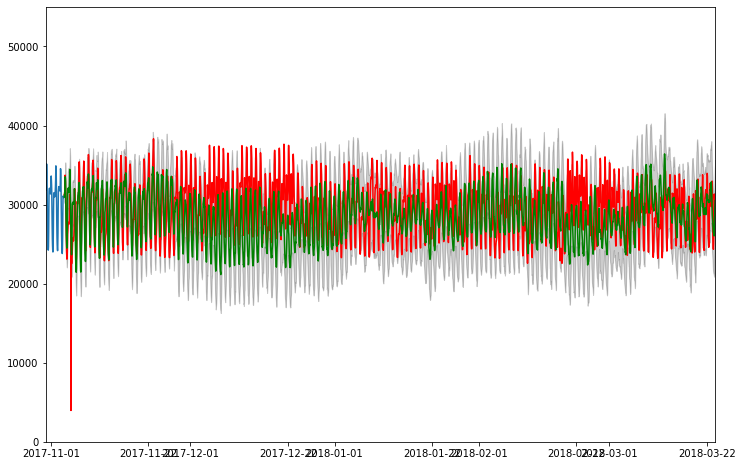

In [116]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index, X_train['demand'].values)
plt.plot(X_walk1.index, X_walk1['demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

(0, 10000)

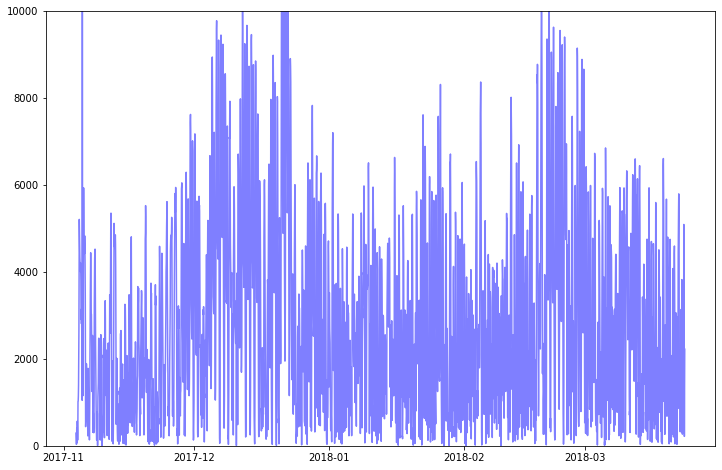

In [117]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
plt.plot(pred_times3, residuals3, c='b', alpha=0.5)
plt.ylim(0, 10000)

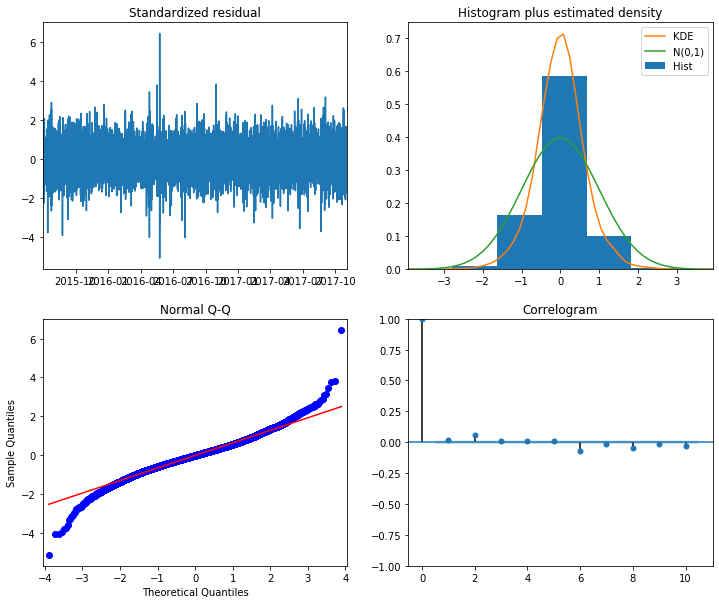

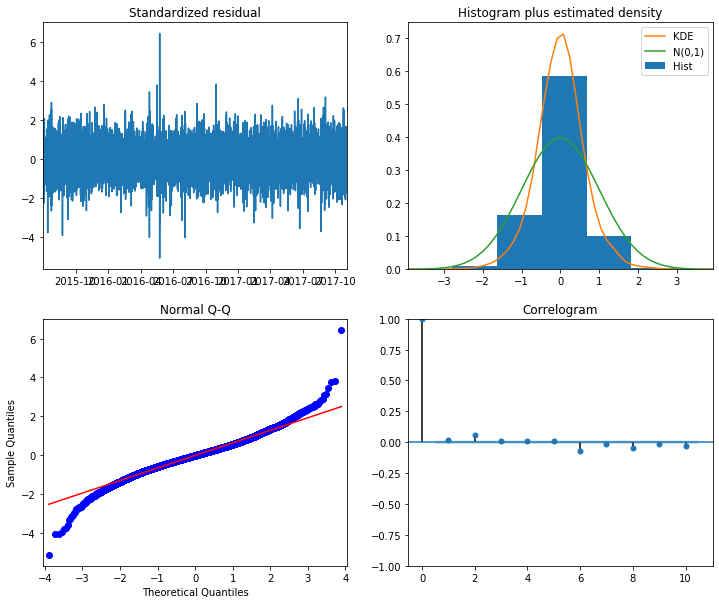

In [118]:
res3.plot_diagnostics(figsize=[12,10])